In [647]:
# Standard library imports
from enum import IntEnum
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import importlib.util


import testing.tpch.setup as tpch_setup



In [648]:
# Configuration
SCALE_FACTOR = 0.5
RESULTS_PATH = f"{os.curdir}/results/single-queries/tpch/2025-05-10-15H/"
PERCENTILE_THRESHOLD = 0.8  # Used for filtering high-performing materializations

# Table size definitions based on scale factor
TPCH_TABLE_SIZES = {
    "customer": int(150000 * SCALE_FACTOR),
    "lineitem": int(6000000 * SCALE_FACTOR),
    "orders": int(1500000 * SCALE_FACTOR),
    "part": int(200000 * SCALE_FACTOR),
    "partsupp": int(800000 * SCALE_FACTOR),
    "supplier": int(10000 * SCALE_FACTOR),
    "nation": 25,  # Not scaled
    "region": 5    # Not scaled
}

# Load query definitions
QUERIES = tpch_setup.QUERIES

# Define join categories


class JoinCategory(IntEnum):
    """Categories for join operations based on table sizes and materialization state"""
    NO_COUNTERPART = 0
    SMALLER_TB__MATERIALIZED_CP = 1
    SMALLER_TB__UNMATERIALIZED_CP = 2
    LARGER_TB__MATERIALIZED_CP = 3
    LARGER_TB__UNMATERIALIZED_CP = 4

In [649]:
def get_table_size(column_name):
    """Get the table size for a given column based on its prefix"""
    if column_name.startswith("c_"):
        return TPCH_TABLE_SIZES["customer"]
    elif column_name.startswith("l_"):
        return TPCH_TABLE_SIZES["lineitem"]
    elif column_name.startswith("o_"):
        return TPCH_TABLE_SIZES["orders"]
    elif column_name.startswith("p_"):
        return TPCH_TABLE_SIZES["part"]
    elif column_name.startswith("ps_"):
        return TPCH_TABLE_SIZES["partsupp"]
    elif column_name.startswith("s_"):
        return TPCH_TABLE_SIZES["supplier"]
    elif column_name.startswith("n_"):
        return TPCH_TABLE_SIZES["nation"]
    elif column_name.startswith("r_"):
        return TPCH_TABLE_SIZES["region"]
    else:
        return 0


def get_table_name(column_name):
    """Get the table name for a given column based on its prefix"""
    if column_name.startswith("c_"):
        return "customer"
    elif column_name.startswith("l_"):
        return "lineitem"
    elif column_name.startswith("o_"):
        return "orders"
    elif column_name.startswith("p_"):
        return "part"
    elif column_name.startswith("ps_"):
        return "partsupp"
    elif column_name.startswith("s_"):
        return "supplier"
    elif column_name.startswith("n_"):
        return "nation"
    elif column_name.startswith("r_"):
        return "region"
    else:
        return "unknown"

#Adds table size, relative improvement, and Column type
def load_results_data():
    """Load and preprocess the experiment results data"""
    results_df = pd.read_csv(RESULTS_PATH + "expanded_results.csv")

    # Clean up any unnamed columns
    if "Unnamed: 0" in results_df.columns:
        results_df = results_df.drop(columns=["Unnamed: 0"])

    # Add table size information
    results_df["Table size"] = results_df.apply(
        lambda row: get_table_size(row["Materialization"]), axis=1)

    # Calculate relative improvement
    results_df["Relative Improvement"] = results_df.apply(
        lambda row: row["Improvement"] / row["Previous Time"], axis=1
    )

    # Add column type information
    results_df["Column Type"] = results_df.apply(
        lambda row: tpch_setup.COLUMN_MAP[row["Materialization"]]["type"]
        if row["Materialization"] in tpch_setup.COLUMN_MAP else "Unknown",
        axis=1
    )

    return results_df


# Functions for analyzing query usage patterns

def get_field_frequency_for_query(query_name, materialized_column):
    """Count total occurrences of a column in a query"""
    q = QUERIES[query_name]
    cols = q.columns_used()
    return cols.count(materialized_column)


def get_field_join_frequency_for_query(query_name, materialized_column):
    """Count how many times a column is used in joins"""
    q = QUERIES[query_name]
    cols = q.columns_used_in_join()
    if materialized_column in cols:
        return len(cols[materialized_column])
    else:
        return 0


def get_field_where_frequency_for_query(query_name, materialized_column):
    """Count how many times a column is used in WHERE clauses"""
    q = QUERIES[query_name]
    cols = q.columns_used_with_position()["where"]
    return cols.count(materialized_column)


def get_field_select_frequency_for_query(query_name, materialized_column):
    """Count how many times a column is used in SELECT clauses"""
    q = QUERIES[query_name]
    cols = q.columns_used_with_position()["select"]
    return cols.count(materialized_column)


def get_field_group_by_frequency_for_query(query_name, materialized_column):
    """Count how many times a column is used in GROUP BY clauses"""
    q = QUERIES[query_name]
    cols = q.columns_used_with_position()["group_by"]
    return cols.count(materialized_column)


def get_field_order_by_frequency_for_query(query_name, materialized_column):
    """Count how many times a column is used in ORDER BY clauses"""
    q = QUERIES[query_name]
    cols = q.columns_used_with_position()["order_by"]
    return cols.count(materialized_column)


def get_self_join_frequency_for_query(query_name, materialized_column):
    """Count how many times a column is used in self-joins"""
    q = QUERIES[query_name]
    cols = q.columns_used_with_position()
    if "self_join" in cols and materialized_column in cols["self_join"].keys():
        return cols["self_join"][materialized_column]
    return 0


def get_join_category(query_name, materialized_column, previous_materializations, table_size):
    """Determine the join category for a materialized column"""
    q = QUERIES[query_name]

    # Check if the column is used in a join
    if materialized_column not in q.columns_used_in_join():
        return JoinCategory.NO_COUNTERPART

    counterpart = q.columns_used_in_join()[materialized_column][0]
    if counterpart is None:
        return JoinCategory.NO_COUNTERPART

    is_counterpart_materialized = counterpart in previous_materializations

    table_size_materialized = table_size
    table_size_counterpart = get_table_size(counterpart)

    if table_size_materialized > table_size_counterpart:
        return JoinCategory.LARGER_TB__MATERIALIZED_CP if is_counterpart_materialized else JoinCategory.LARGER_TB__UNMATERIALIZED_CP
    elif table_size_materialized < table_size_counterpart:
        return JoinCategory.SMALLER_TB__MATERIALIZED_CP if is_counterpart_materialized else JoinCategory.SMALLER_TB__UNMATERIALIZED_CP
    else:
        # Equal size - default to smaller table category
        return JoinCategory.SMALLER_TB__MATERIALIZED_CP if is_counterpart_materialized else JoinCategory.SMALLER_TB__UNMATERIALIZED_CP


def get_join_counterpart_info(query_name, materialized_column, previous_materializations):
    """Get information about the join counterpart of a materialized column"""
    q = QUERIES[query_name]

    if materialized_column not in q.columns_used_in_join():
        return None, None, False

    counterpart = q.columns_used_in_join()[materialized_column][0]
    if counterpart is None:
        return None, None, False

    counterpart_table = get_table_name(counterpart)
    counterpart_size = get_table_size(counterpart)
    is_materialized = counterpart in previous_materializations

    return counterpart_table, counterpart_size, is_materialized


# Data preparation functions

def add_usage_frequencies(df):
    """Add column usage frequency information to the dataframe"""
    df["Total Frequency"] = df.apply(
        lambda row: get_field_frequency_for_query(row["Query"], row["Materialization"]), axis=1
    )

    df["Join Frequency"] = df.apply(
        lambda row: get_field_join_frequency_for_query(row["Query"], row["Materialization"]), axis=1
    )

    df["Where Frequency"] = df.apply(
        lambda row: get_field_where_frequency_for_query(row["Query"], row["Materialization"]), axis=1
    )

    df["Select Frequency"] = df.apply(
        lambda row: get_field_select_frequency_for_query(row["Query"], row["Materialization"]), axis=1
    )

    df["Group By Frequency"] = df.apply(
        lambda row: get_field_group_by_frequency_for_query(row["Query"], row["Materialization"]), axis=1
    )

    df["Order By Frequency"] = df.apply(
        lambda row: get_field_order_by_frequency_for_query(row["Query"], row["Materialization"]), axis=1
    )

    df["Self Join Frequency"] = df.apply(
        lambda row: get_self_join_frequency_for_query(row["Query"], row["Materialization"]), axis=1
    )

    return df


def add_rankings(df):
    """Add ranking information based on improvement"""

    # Global rankings
    df["Global Rank"] = df["Improvement"].rank(ascending=False).astype(int)
    df["Global Percentile"] = df["Improvement"].rank(pct=True).round(2)

    return df


def prepare_single_join_data(df):
    """Extract and prepare data for single join analysis"""
    # Filter for single join cases
    single_join_df = df[(df["Join Frequency"] == 1) &
                        (df["Where Frequency"] == 0)].copy()

    # Add join-specific rankings
    single_join_df["Global Join Rank"] = single_join_df["Improvement"].rank(
        ascending=False)
    single_join_df["Global Join Percentile"] = single_join_df["Improvement"].rank(
        pct=True).round(2)

    # Add join category information
    single_join_df["Join Category"] = single_join_df.apply(
        lambda row: get_join_category(
            row["Query"],
            row["Materialization"],
            row["Previous Materializations"],
            row["Table size"]
        ),
        axis=1
    )

    # Add counterpart information
    join_counterparts = single_join_df.apply(
        lambda row: get_join_counterpart_info(
            row["Query"],
            row["Materialization"],
            row["Previous Materializations"]
        ),
        axis=1
    )

    single_join_df["Join Counterpart Table Name"] = join_counterparts.apply(
        lambda x: x[0] if x else None)
    single_join_df["Join Counterpart Table Size"] = join_counterparts.apply(
        lambda x: x[1] if x else None)
    single_join_df["Join Counterpart Is Materialized"] = join_counterparts.apply(
        lambda x: x[2] if x else False)

    return single_join_df


def prepare_single_where_data(df):
    """Extract and prepare data for single WHERE clause analysis"""
    # Filter for single WHERE cases
    single_where_df = df[(df["Where Frequency"] == 1) &
                         (df["Join Frequency"] == 0)].copy()

    # Add WHERE-specific rankings
    single_where_df["Global Where Percentile"] = single_where_df["Improvement"].rank(
        pct=True)

    return single_where_df

In [650]:
# Visualization functions

def plot_scatter(x, y, title, xlabel, ylabel, colorby=None, cmap='tab20', alpha=0.5, figsize=(12, 8)):
    """Create a scatter plot with optional color coding"""
    fig = plt.figure(figsize=figsize)

    if colorby is not None:
        categories = colorby.astype('category').cat.codes
        scatter = plt.scatter(x, y, c=categories, alpha=alpha, cmap=cmap)

        # Add colorbar
        colorbar = plt.colorbar()
        colorbar.set_ticks(range(len(colorby.unique())))
        colorbar.set_ticklabels(sorted(colorby.unique()))
    else:
        scatter = plt.scatter(x, y, alpha=alpha)

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout()

    return fig, plt.gca()


def plot_violin(data_dict, title, xlabel, ylabel, figsize=(12, 8), showmeans=True):
    """Create a violin plot from a dictionary of data"""
    fig = plt.figure(figsize=figsize)

    # Convert dict values to list
    data_values = list(data_dict.values())

    # Create violin plot
    violin_plot = plt.violinplot(data_values, showmeans=showmeans)

    # Set x-axis ticks and labels
    plt.xticks(
        range(1, len(data_dict) + 1),
        list(data_dict.keys()),
        rotation=45,
        ha='right'
    )

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Add counts above each violin
    ax = plt.gca()
    try:
        max_height = max([max(v) if len(v) > 0 else 0 for v in data_values])
        for i, (key, values) in enumerate(data_dict.items(), 1):
            ax.text(i, max_height * 1.02,
                    f'n={len(values)}', ha='center', va='bottom')
    except ValueError:
        # Handle empty data
        pass

    # Adjust layout
    plt.tight_layout()

    return fig, plt.gca()


def plot_bar(x, y, title, xlabel, ylabel, figsize=(15, 6), annotate=None, rotation=45):
    """Create a bar plot with optional annotation"""
    fig = plt.figure(figsize=figsize)
    bars = plt.bar(x, y)

    # Set x-axis labels
    plt.xticks(rotation=rotation, ha='right')

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Add annotations if provided
    if annotate is not None:
        ax = plt.gca()
        max_height = max(y)
        for i, (bar, ann) in enumerate(zip(bars, annotate)):
            ax.text(
                bar.get_x() + bar.get_width() / 2.,
                bar.get_height() + max_height * 0.02,
                f'n={ann}', ha='center', va='bottom'
            )

    # Adjust layout
    plt.tight_layout()

    return fig, plt.gca()

In [651]:
def get_label_for_frequency_combination(row):
    """Convert frequency columns to a readable label"""
    freqs = [row["Join Frequency"], row["Where Frequency"],
             row["Select Frequency"], row["Group By Frequency"]]
    labels = ["Join", "Where", "Select", "Group By"]
    active = [l for f, l in zip(freqs, labels) if f == 1]
    return ", ".join(active) if active else "Other"

def get_simplified_category(row):
    """Convert to simplified categories: Join, Where, Join and Where, or Other"""
    join_freq = row["Join Frequency"]
    where_freq = row["Where Frequency"]

    if join_freq == 1 and where_freq == 0:
        return "Join"
    elif join_freq == 0 and where_freq == 1:
        return "Where"
    elif join_freq == 1 and where_freq == 1:
        return "Join and Where"
    else:
        return "Other"





def binarize_frequencies(df, cols):
    """Binarize frequency columns by setting any frequency greater than 0 to 1"""
    df_copy = df.copy()
    for col in cols:
        df_copy[f"{col} Frequency"] = df_copy[f"{col} Frequency"].apply(
            lambda x: int(x > 0))
    return df_copy


def group_and_sum(df, group_cols, sum_col, sum_name, count_name):
    """Group dataframe by specified columns and compute count and sum of another column"""
    grouped_count = df.groupby(group_cols).size().reset_index(name=count_name)
    grouped_sum = df.groupby(group_cols).agg(
        **{sum_name: (sum_col, 'sum')}).reset_index()
    return grouped_count.merge(grouped_sum, on=group_cols, how="left")


In [652]:
# Analysis functions

def analyze_frequency_patterns(df, percentile_threshold=PERCENTILE_THRESHOLD):
    """Analyze how column usage patterns affect improvement percentiles"""
    # Create filtered dataframes
    filtered_global = df[df["Global Percentile"] >= percentile_threshold]

    # Add column with readable label for frequency combination
    df["Label"] = df.apply(get_label_for_frequency_combination, axis=1)

    # Group by frequency combination and count occurrences
    freq_cols = ["Join Frequency", "Where Frequency",
                 "Select Frequency", "Group By Frequency"]

    # Process for global percentile
    filtered_counts_global = (
        filtered_global
        .groupby(freq_cols)
        .size()
        .reset_index(name='FilteredCount')
    )

    # Get total counts
    total_counts = (
        df
        .groupby(freq_cols)
        .size()
        .reset_index(name='TotalCount')
    )

    # Merge and compute normalized counts for global percentile
    counts_global = pd.merge(
        filtered_counts_global,
        total_counts,
        on=freq_cols,
        how="inner"
    )
    counts_global['Label'] = counts_global.apply(
        lambda row: get_label_for_frequency_combination(row),
        axis=1
    )
    counts_global['Normalized'] = counts_global['FilteredCount'] / \
        counts_global['TotalCount']
    counts_global = counts_global.sort_values('FilteredCount', ascending=False)

    return counts_global


def analyze_join_patterns(single_join_df, percentile_threshold=PERCENTILE_THRESHOLD):
    """Analyze how join patterns affect improvement in single join cases"""
    # Filter data based on percentile threshold
    high_global_joins = single_join_df[single_join_df['Global Join Percentile']
                                       >= percentile_threshold]

    # Group by join category and count

    gj_counts = high_global_joins.groupby(
        'Join Category').size().reset_index(name='FilteredCount')
    gj_counts['Sum'] = high_global_joins.groupby(
        'Join Category')['Improvement'].sum().values

    # Get total counts by category
    total_counts = single_join_df.groupby(
        'Join Category').size().reset_index(name='TotalCount')

    # Prepare results

    gj_results = pd.merge(gj_counts, total_counts,
                          on='Join Category', how='inner')
    gj_results['Normalized'] = gj_results['FilteredCount'] / \
        gj_results['TotalCount']

    return gj_results


def analyze_where_patterns(single_where_df, percentile_threshold=PERCENTILE_THRESHOLD):
    """Analyze how WHERE clause patterns affect improvement"""
    # Filter data based on percentile threshold
    high_global_where = single_where_df[single_where_df['Global Where Percentile']
                                        >= percentile_threshold]

    # Analyze by column type
    col_type_global = high_global_where.groupby(
        'Column Type').size().reset_index(name='Count')
    col_type_global['Sum'] = high_global_where.groupby(
        'Column Type')['Improvement'].sum().values

    # Analyze by table size

    table_size_global = high_global_where.groupby(
        'Table size').size().reset_index(name='Count')
    table_size_global['Sum'] = high_global_where.groupby(
        'Table size')['Improvement'].sum().values

    return {
        'column_type': {'global': col_type_global},
        'table_size': {'global': table_size_global}
    }


def analyze_binarized_frequencies(df, percentile_threshold=PERCENTILE_THRESHOLD):
    """Analyze binary usage patterns (e.g., whether a column is used in a clause at all)"""
    # Define frequency columns to binarize
    frequency_cols = ["Join", "Where", "Select", "Group By"]

    # Create filtered dataframes
    filtered_global = df[df["Global Percentile"] >= percentile_threshold]

    # Binarize frequencies (0/1 instead of actual counts)
    binary_df = binarize_frequencies(df, frequency_cols)
    binary_filtered_global = binarize_frequencies(
        filtered_global, frequency_cols)

    # Add labels
    binary_df["Label"] = binary_df.apply(
        get_label_for_frequency_combination, axis=1)

       # Add simplified category labels
    binary_df["Simplified Category"] = binary_df.apply(
        get_simplified_category, axis=1)

    # Define grouping columns
    group_cols = [f"{col} Frequency" for col in frequency_cols]


    # Process global percentile data
    total_grouped = group_and_sum(
        binary_df,
        group_cols=group_cols,
        sum_col="Improvement",
        sum_name="TotalSum",
        count_name="Count"
    )

    filtered_grouped_global = group_and_sum(
        binary_filtered_global,
        group_cols=group_cols,
        sum_col="Improvement",
        sum_name="FilteredSum",
        count_name="FilteredCount"
    )

    binary_counts_global = pd.merge(
        filtered_grouped_global,
        total_grouped,
        on=group_cols,
        how="inner"
    )

    binary_counts_global["Label"] = binary_counts_global.apply(
        get_label_for_frequency_combination, axis=1)
    binary_counts_global["Normalized"] = binary_counts_global["FilteredCount"] / \
        binary_counts_global["Count"]
    binary_counts_global = binary_counts_global.sort_values(
        'FilteredCount', ascending=False)

    # TODO: Fix order
    # Map to original order
    # binary_counts_global["sort_order"] = binary_counts_global["Label"].map(
    #     {label: i for i, label in enumerate(binary_counts_query["Label"])}
    # )
    # binary_counts_global = binary_counts_global.sort_values('sort_order')

    return binary_df, binary_counts_global



def analyze_join_category_by_table_size(single_join_df):
    """Analyze join categories for each table size"""
    # Create violin plot data for Global percentiles by join category
    join_category_data = {}

    # Get all table sizes
    table_sizes = {
        5: 'region (5 rows)',
        25: 'nation (25 rows)',
        5000: 'supplier (5000 rows)',
        75000: 'customer (75000 rows)',
        100000: 'part (100000 rows)',
        400000: 'partsupp (400000 rows)',
        750000: 'orders (750000 rows)',
        3000000: 'lineitem (3000000 rows)'
    }

    # Category labels
    category_labels = {
        JoinCategory.NO_COUNTERPART: 'No Counterpart',
        JoinCategory.SMALLER_TB__MATERIALIZED_CP: 'Smaller Table Materialized CP',
        JoinCategory.SMALLER_TB__UNMATERIALIZED_CP: 'Smaller Table Unmaterialized CP',
        JoinCategory.LARGER_TB__MATERIALIZED_CP: 'Larger Table Materialized CP',
        JoinCategory.LARGER_TB__UNMATERIALIZED_CP: 'Larger Table Unmaterialized CP'
    }

    # Prepare data for each table size
    for size, label in table_sizes.items():
        join_category_data[size] = {}
        join_category_data[size]['global'] = {}
        join_category_data[size]['counts'] = {}

        # Get data for each join category within this table size
        for cat in JoinCategory:
            df_subset = single_join_df[(single_join_df['Table size'] == size) &
                                       (single_join_df['Join Category'] == cat)]

            if len(df_subset) > 0:
                cat_label = category_labels[cat]
                join_category_data[size]['global'][cat_label] = df_subset['Global Join Percentile']
                join_category_data[size]['counts'][cat_label] = len(df_subset)

    return join_category_data, table_sizes, category_labels


def analyze_join_counterparts(single_join_df):
    """Analyze join counterparts for each table size"""
    counterpart_data = {}

    # Get all table sizes
    table_sizes = {
        5: 'region (5 rows)',
        25: 'nation (25 rows)',
        5000: 'supplier (5000 rows)',
        75000: 'customer (75000 rows)',
        100000: 'part (100000 rows)',
        400000: 'partsupp (400000 rows)',
        750000: 'orders (750000 rows)',
        3000000: 'lineitem (3000000 rows)'
    }

    # Prepare data for each table size
    for size, label in table_sizes.items():
        counterpart_data[size] = {}
        counterpart_data[size]['global'] = {}
        counterpart_data[size]['counts'] = {}

        # Get data for this table size
        df_subset = single_join_df[single_join_df['Table size'] == size]

        if len(df_subset) > 0:
            # Group by counterpart table
            for cp_name, cp_size in df_subset[['Join Counterpart Table Name', 'Join Counterpart Table Size']].dropna().drop_duplicates().sort_values('Join Counterpart Table Size', ascending=False).values:
                # Get data for materialized counterpart
                mat_data = df_subset[
                    (df_subset['Join Counterpart Table Name'] == cp_name) &
                    (df_subset['Join Counterpart Is Materialized'] == True)
                ]

                # Get data for unmaterialized counterpart
                unmat_data = df_subset[
                    (df_subset['Join Counterpart Table Name'] == cp_name) &
                    (df_subset['Join Counterpart Is Materialized'] == False)
                ]

                if len(mat_data) > 0:
                    label = f'{cp_name}\n{int(cp_size)}\nMat.'
                    counterpart_data[size]['global'][label] = mat_data['Global Join Percentile']
                    counterpart_data[size]['counts'][label] = len(mat_data)

                if len(unmat_data) > 0:
                    label = f'{cp_name}\n{int(cp_size)}\nUnmat.'
                    counterpart_data[size]['global'][label] = unmat_data['Global Join Percentile']
                    counterpart_data[size]['counts'][label] = len(unmat_data)

    return counterpart_data, table_sizes

# Main Section

In [653]:
results_df = load_results_data()
results_df = add_usage_frequencies(results_df)
results_df = add_rankings(results_df)
single_join_df = prepare_single_join_data(results_df)
single_join_df




,Query,Materialization,Execution Time,Previous Time,Improvement,Previous Materializations,Table size,Relative Improvement,Column Type,Total Frequency,...,Order By Frequency,Self Join Frequency,Global Rank,Global Percentile,Global Join Rank,Global Join Percentile,Join Category,Join Counterpart Table Name,Join Counterpart Table Size,Join Counterpart Is Materialized
0,q3,c_custkey,2.534976,2.679544,0.144568,[],75000,0.053952,INT,1,...,0,0,7929,0.51,3723.0,0.40,2,orders,750000.0,False
1,q7,c_custkey,6.707714,7.334910,0.627196,[],75000,0.085508,INT,1,...,0,0,6606,0.59,3039.0,0.51,2,orders,750000.0,False
2,q8,c_custkey,6.064164,6.669960,0.605796,[],75000,0.090825,INT,1,...,0,0,6763,0.58,3176.0,0.49,2,orders,750000.0,False
3,q10,c_custkey,2.638145,3.381033,0.742888,[],75000,0.219722,INT,3,...,0,0,3648,0.77,1350.0,0.78,2,orders,750000.0,False
4,q13,c_custkey,1.216612,2.806873,1.590261,[],75000,0.566560,INT,3,...,0,0,419,0.97,163.0,0.97,2,orders,750000.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16054,q21,s_nationkey,7.196941,9.036015,1.839074,"['s_suppkey', 's_name']",5000,0.203527,INT,1,...,0,0,384,0.98,140.0,0.98,4,nation,25.0,False
16058,q15,s_suppkey,0.788124,1.522910,0.734785,"['s_name', 's_phone']",5000,0.482488,INT,3,...,1,0,3932,0.76,1480.0,0.76,0,None,NaN,False
16072,q20,s_nationkey,3.151329,3.179300,0.027971,"['s_suppkey', 's_address']",5000,0.008798,INT,1,...,0,0,10179,0.37,4564.0,0.26,4,nation,25.0,False
16076,q15,s_suppkey,0.784786,1.528962,0.744175,"['s_address', 's_phone']",5000,0.486719,INT,3,...,1,0,3601,0.78,1329.0,0.79,0,None,NaN,False


In [654]:
# Load and prepare data

#Adds table size, relative improvement, and Column type
results_df = load_results_data()

results_df = add_usage_frequencies(results_df)

#Adds both query and global
results_df = add_rankings(results_df)

# Prepare specialized datasets
single_join_df = prepare_single_join_data(results_df)
single_where_df = prepare_single_where_data(results_df)

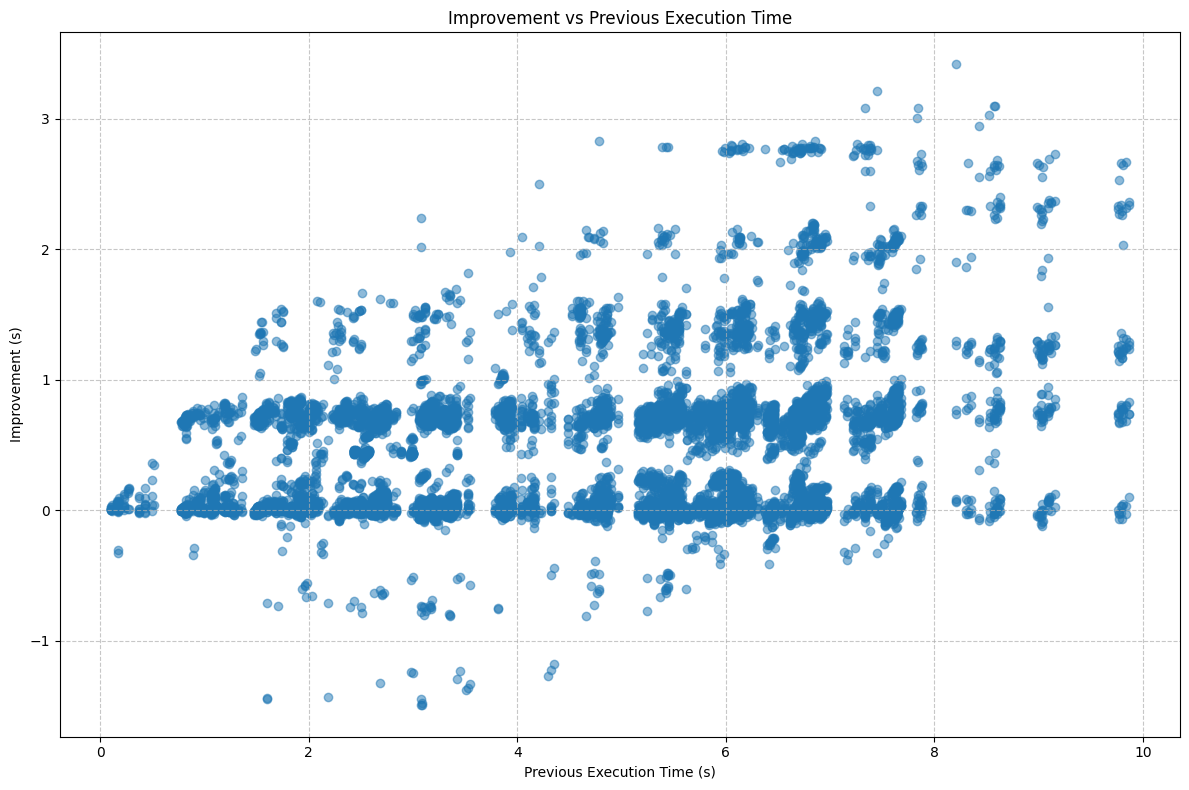

In [655]:
# Create basic improvement plots
fig, ax = plot_scatter(
    results_df['Previous Time'],
    results_df['Improvement'],
    'Improvement vs Previous Execution Time',
    'Previous Execution Time (s)',
    'Improvement (s)'
)

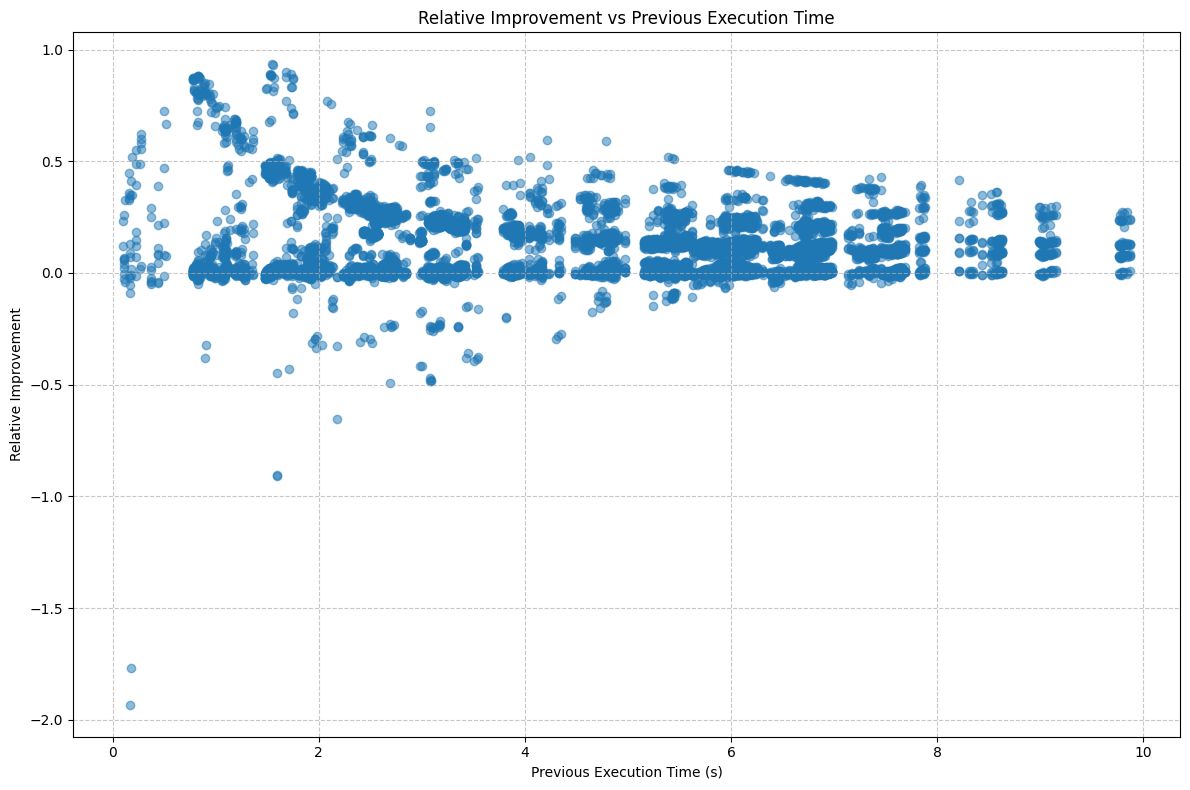

In [656]:
fig, ax = plot_scatter(
    results_df['Previous Time'],
    results_df['Relative Improvement'],
    'Relative Improvement vs Previous Execution Time',
    'Previous Execution Time (s)',
    'Relative Improvement'
)

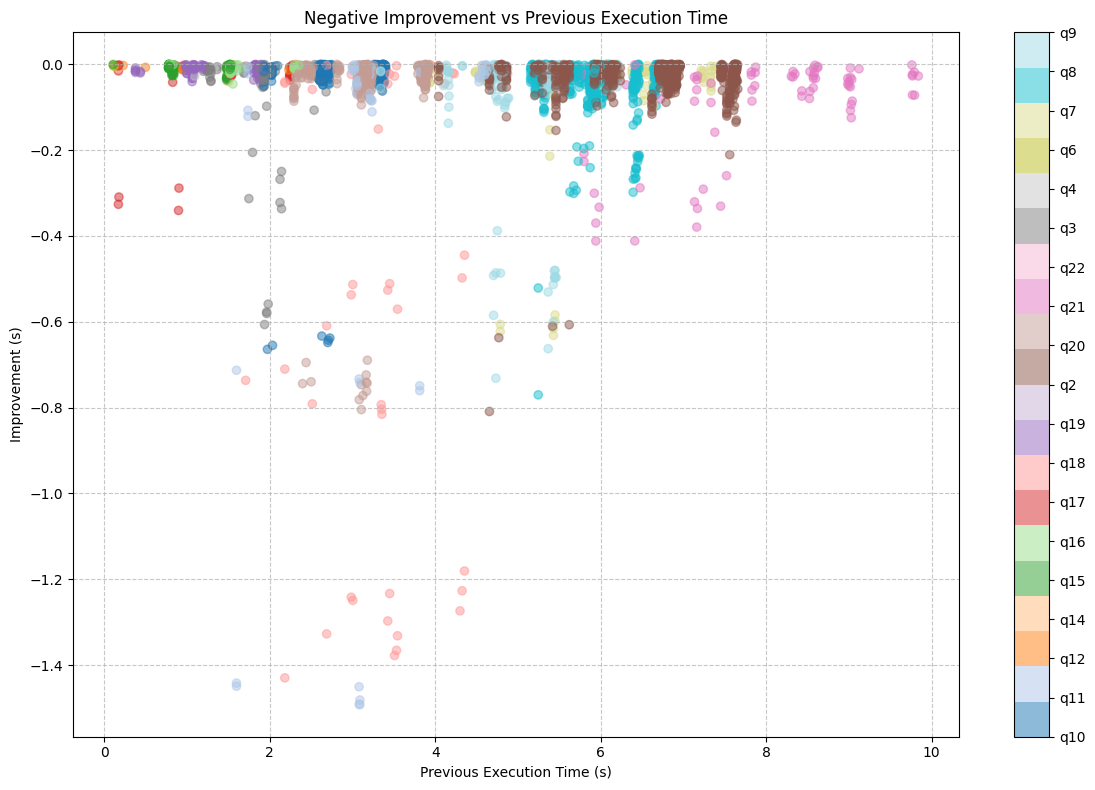

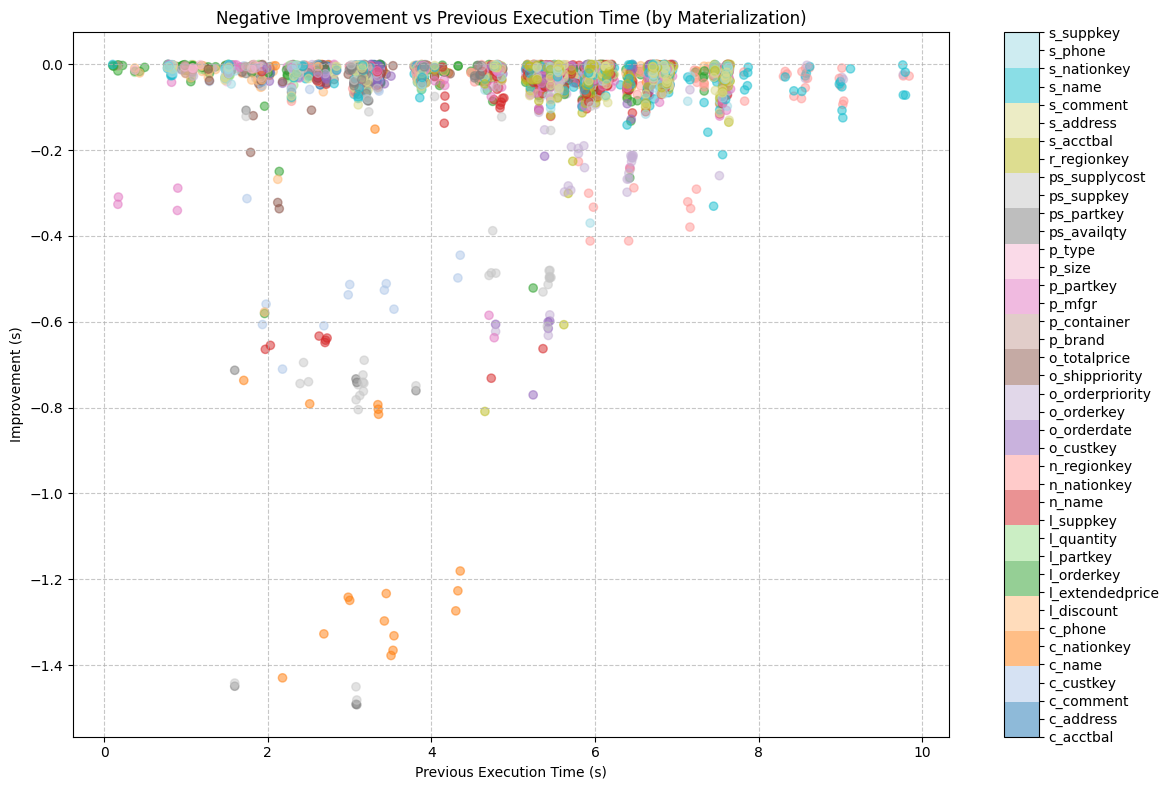

In [657]:
# Create plots for negative improvements
results_df_negative_improvement = results_df[results_df['Improvement'] < 0]

if not results_df_negative_improvement.empty:
    fig, ax = plot_scatter(
        results_df_negative_improvement['Previous Time'],
        results_df_negative_improvement['Improvement'],
        'Negative Improvement vs Previous Execution Time',
        'Previous Execution Time (s)',
        'Improvement (s)',
        colorby=results_df_negative_improvement['Query']
    )


    fig, ax = plot_scatter(
        results_df_negative_improvement['Previous Time'],
        results_df_negative_improvement['Improvement'],
        'Negative Improvement vs Previous Execution Time (by Materialization)',
        'Previous Execution Time (s)',
        'Improvement (s)',
        colorby=results_df_negative_improvement['Materialization']
    )

In [658]:
# TODO: Add non-binarized

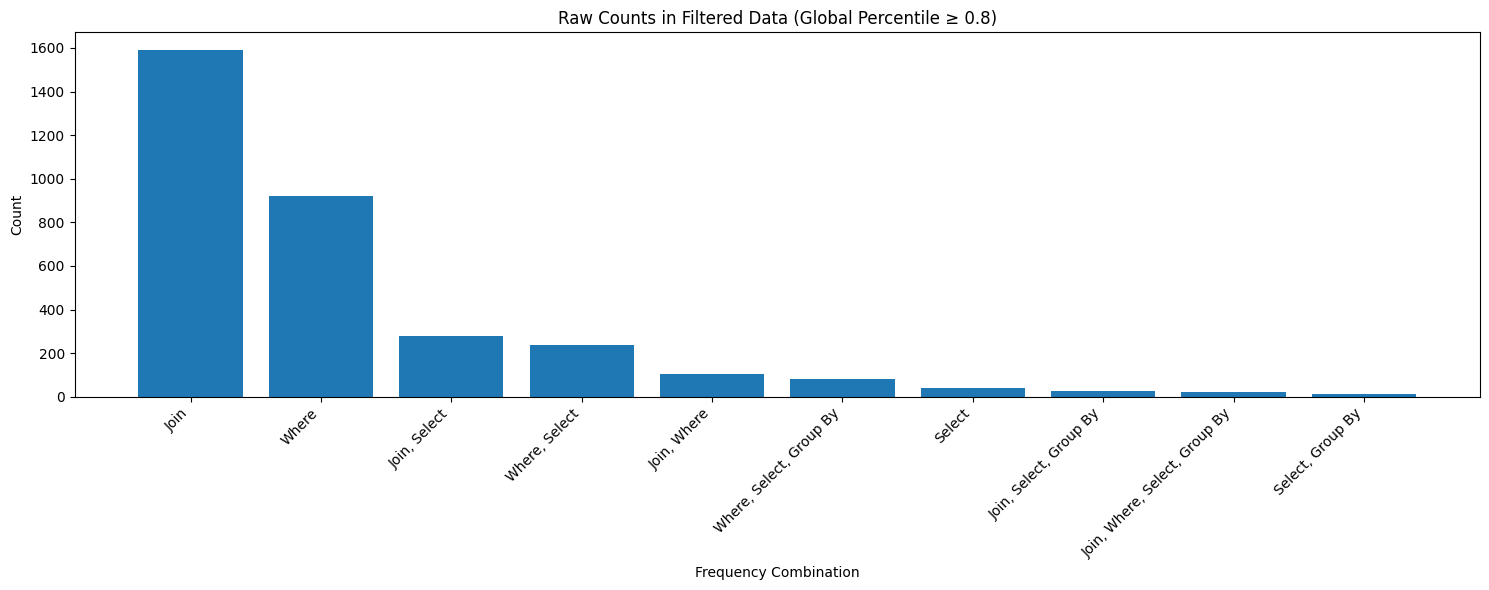

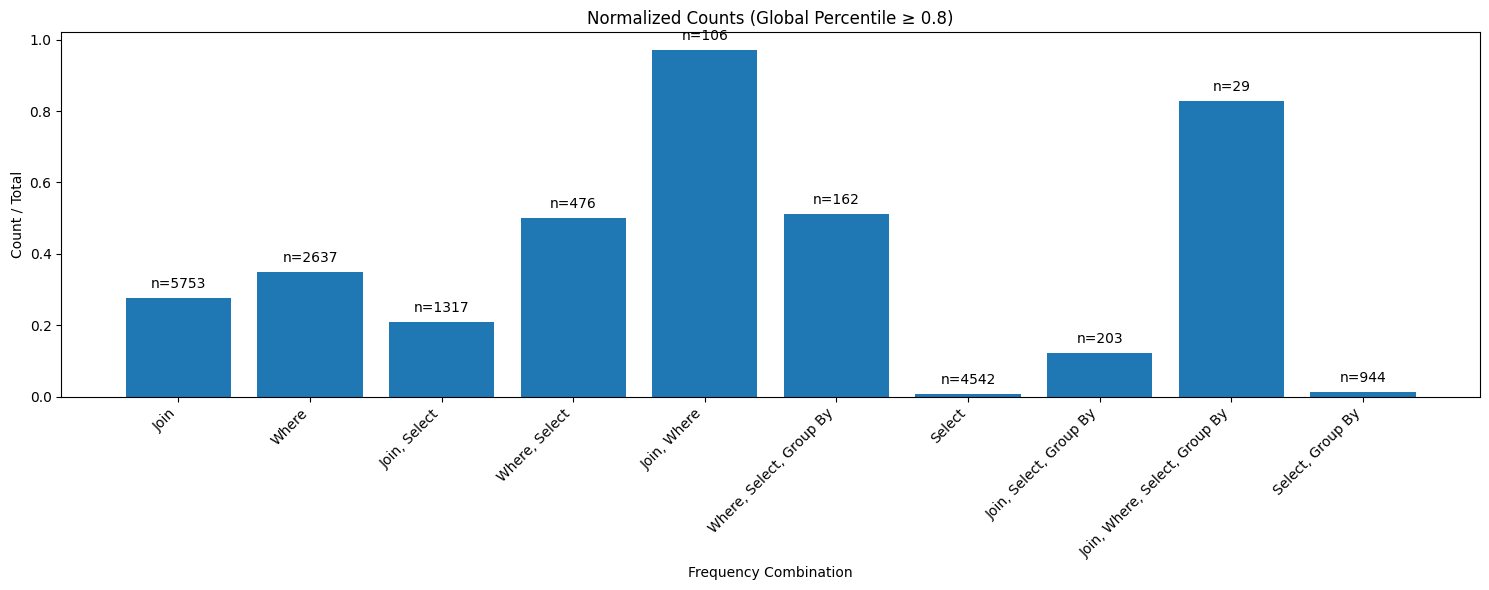

In [659]:
# Analyze frequency patterns
counts_global = analyze_frequency_patterns(results_df)

# Analyze binarized frequency patterns
binary_df, binary_counts_global = analyze_binarized_frequencies(
    results_df)



fig, ax = plot_bar(
    binary_counts_global['Label'],
    binary_counts_global['FilteredCount'],
    f'Raw Counts in Filtered Data (Global Percentile ≥ {PERCENTILE_THRESHOLD})',
    'Frequency Combination',
    'Count'
)

fig, ax = plot_bar(
    binary_counts_global['Label'],
    binary_counts_global['Normalized'],
    f'Normalized Counts (Global Percentile ≥ {PERCENTILE_THRESHOLD})',
    'Frequency Combination',
    'Count / Total',
    annotate=binary_counts_global['Count']
)

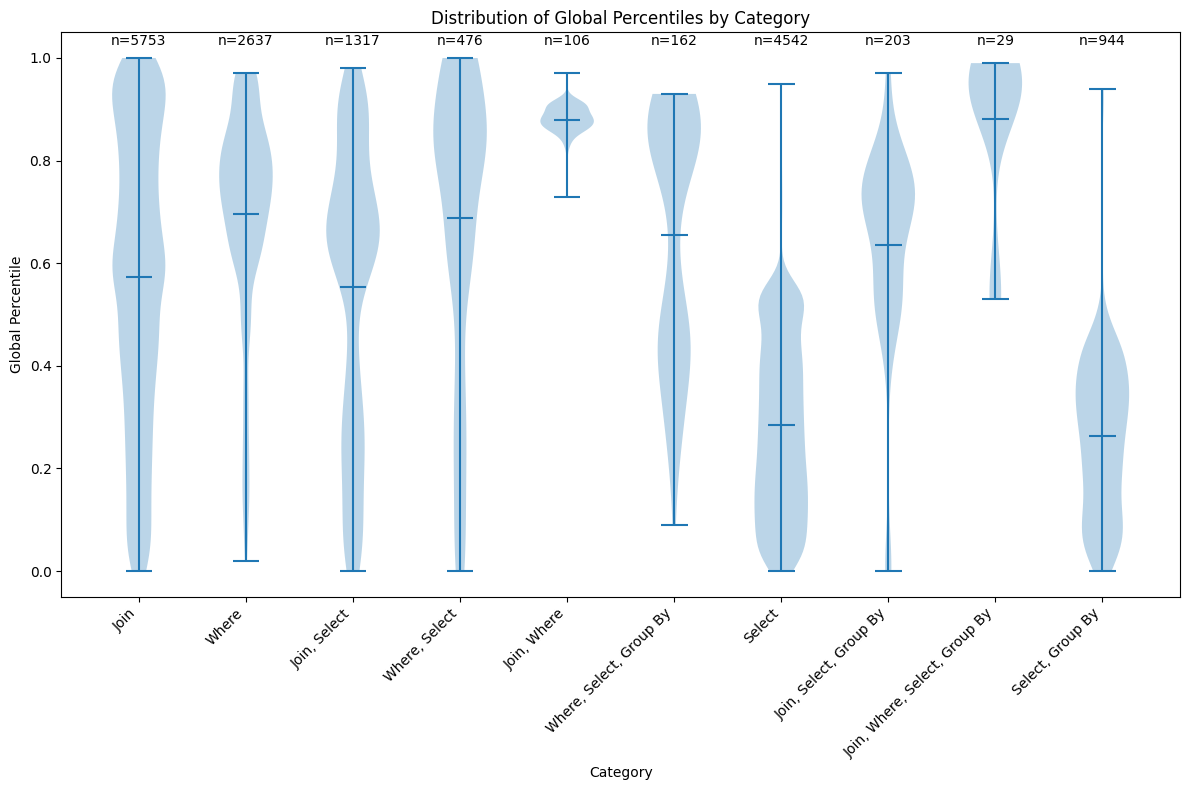

In [660]:
# Create violin plots for binarized frequencies
# TODO: Fix order
# ordered_labels = binary_counts_query['Label'].tolist()


global_violin_data = {
    label: binary_df[binary_df['Label'] == label]['Global Percentile']
    for label in binary_counts_global['Label'].tolist()
}

fig, ax = plot_violin(
    global_violin_data,
    'Distribution of Global Percentiles by Category',
    'Category',
    'Global Percentile'
)

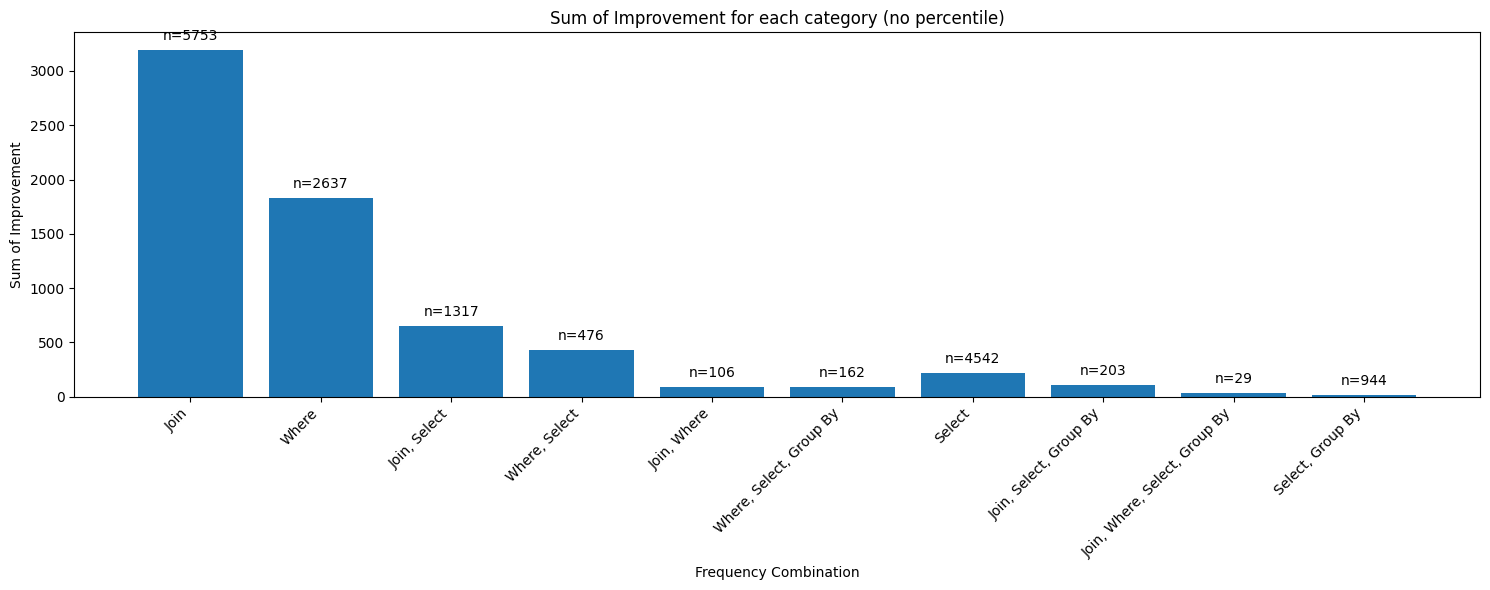

In [661]:
# Create improvement sum bar plot
fig, ax = plot_bar(
    binary_counts_global['Label'],
    binary_counts_global['TotalSum'],
    'Sum of Improvement for each category (no percentile)',
    'Frequency Combination',
    'Sum of Improvement',
    annotate=binary_counts_global['Count']
)

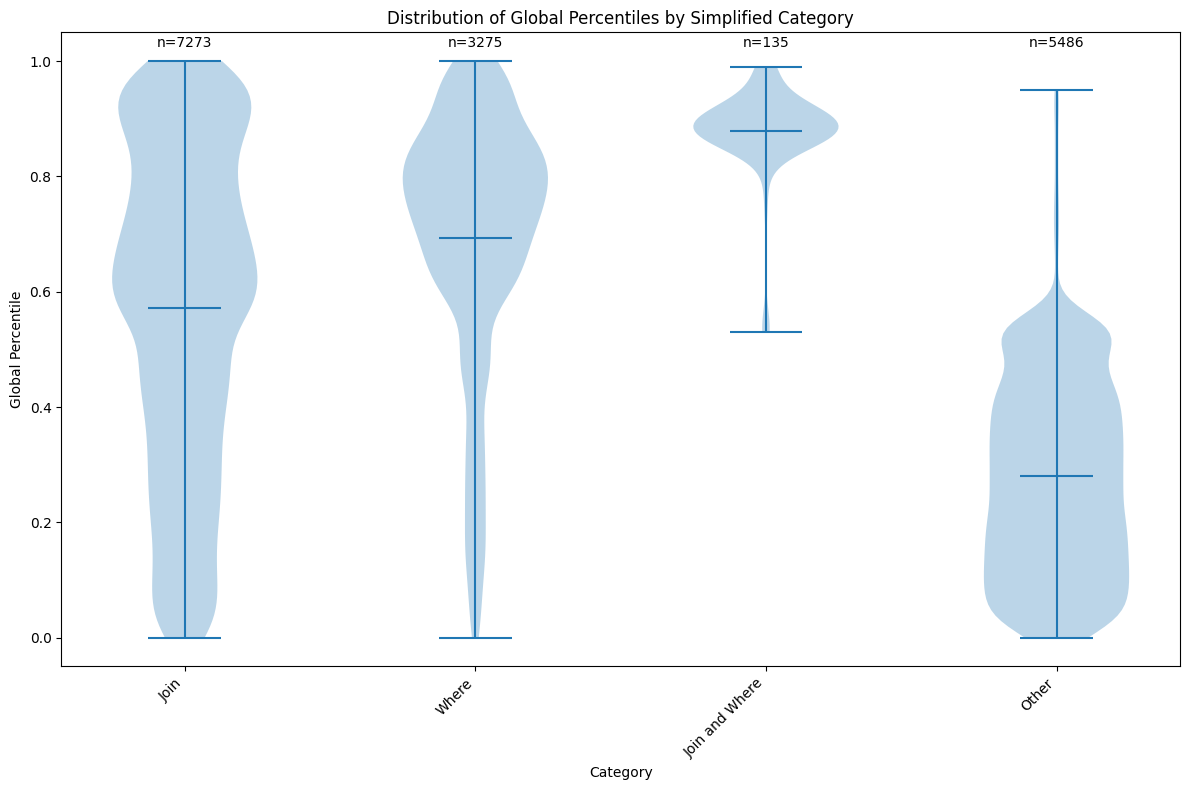

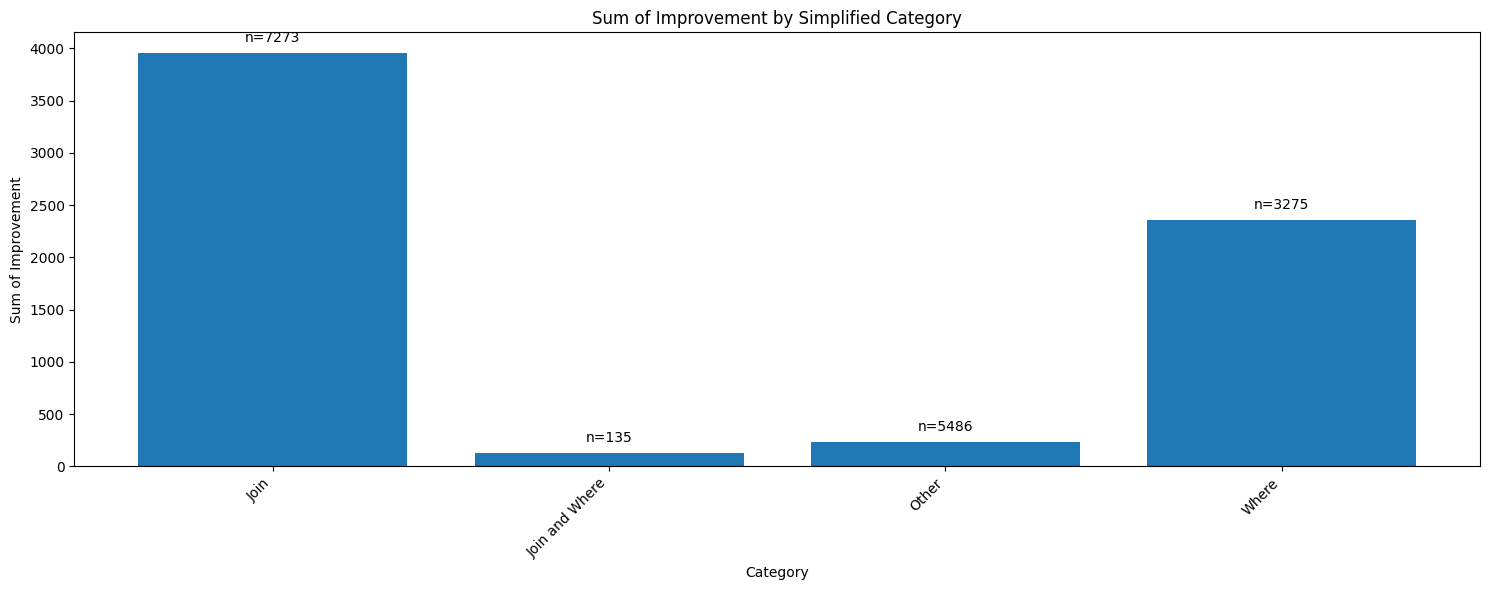

In [662]:
# Create violin plots for simplified categories
simplified_categories = ["Join", "Where", "Join and Where", "Other"]

global_violin_simplified = {
    category: binary_df[binary_df['Simplified Category']
                        == category]['Global Percentile']
    for category in simplified_categories
}


fig, ax = plot_violin(
    global_violin_simplified,
    'Distribution of Global Percentiles by Simplified Category',
    'Category',
    'Global Percentile'
)

# Create improvement sum bar plot for simplified categories
simplified_sum_data = binary_df.groupby('Simplified Category')[
    'Improvement'].sum()
simplified_count_data = binary_df.groupby('Simplified Category').size()

fig, ax = plot_bar(
    simplified_sum_data.index,
    simplified_sum_data.values,
    'Sum of Improvement by Simplified Category',
    'Category',
    'Sum of Improvement',
    annotate=simplified_count_data.values
)

# Single Join Section

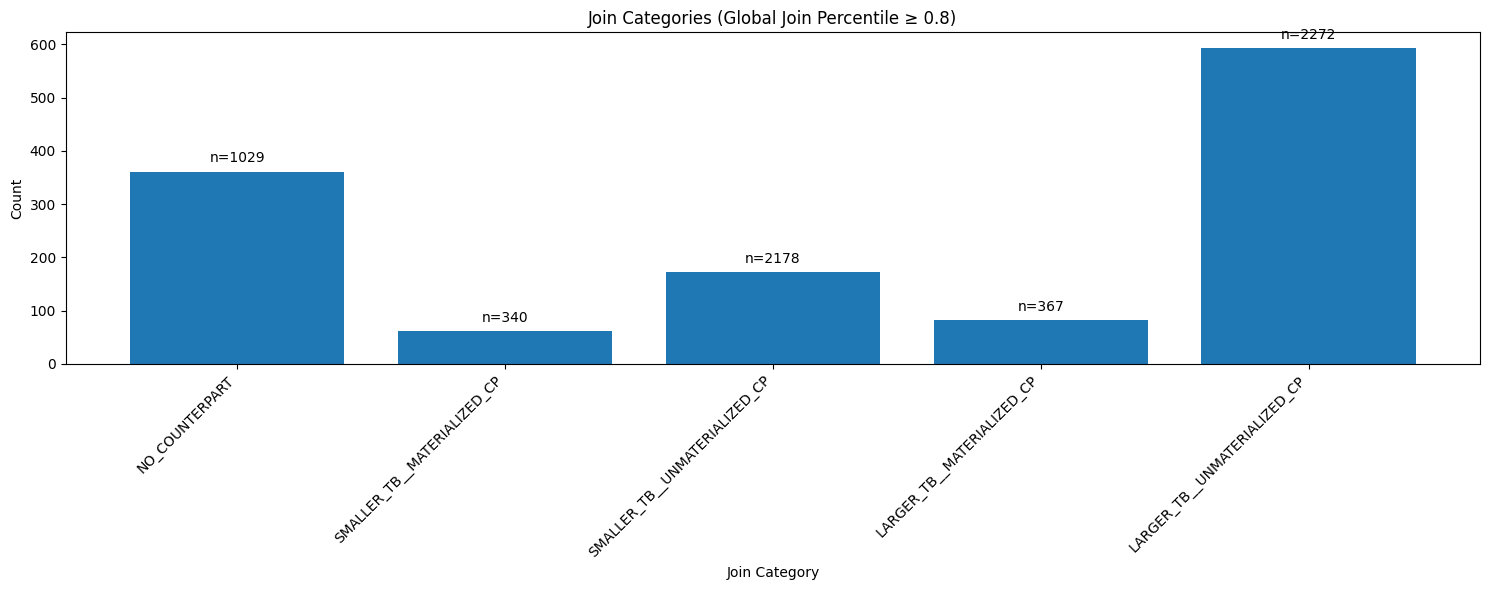

In [663]:
# Analyze join patterns
gj_results = analyze_join_patterns(single_join_df)

# Create plots for join categories
category_labels = [cat.name for cat in JoinCategory]


fig, ax = plot_bar(
    [category_labels[int(cat)] for cat in gj_results['Join Category']],
    gj_results['FilteredCount'],
    f'Join Categories (Global Join Percentile ≥ {PERCENTILE_THRESHOLD})',
    'Join Category',
    'Count',
    annotate=gj_results['TotalCount']
)

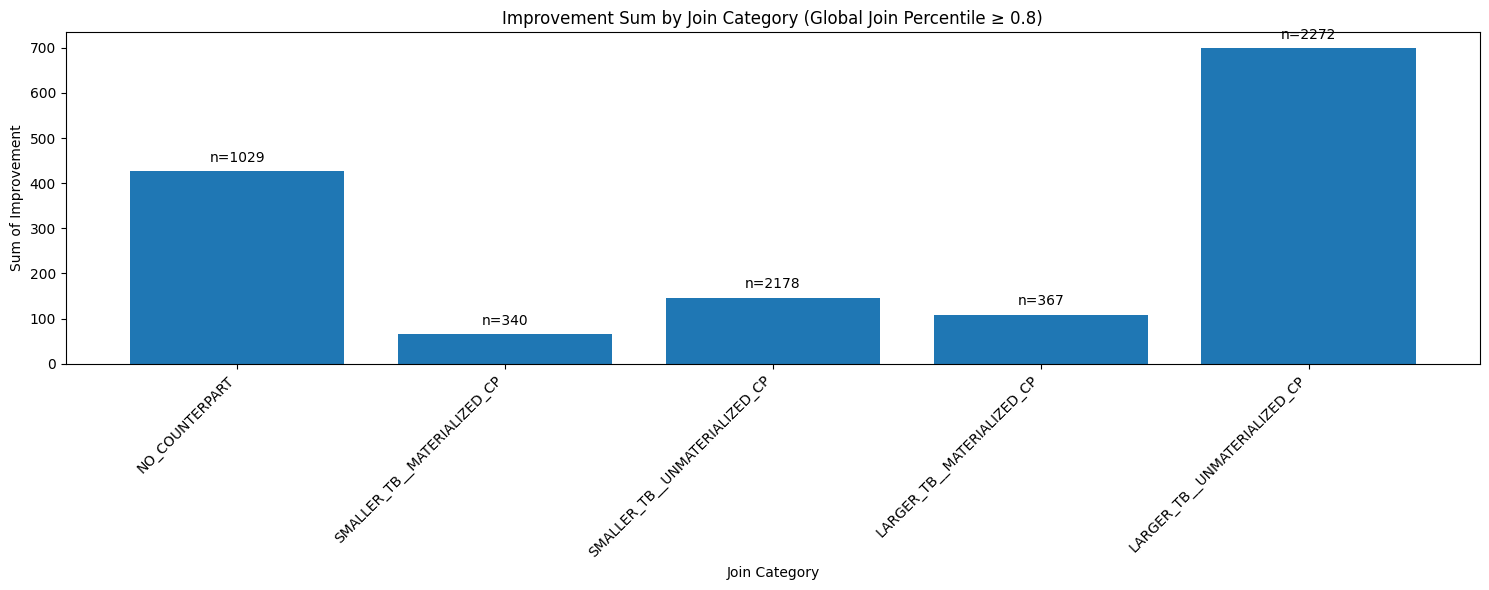

In [664]:
# Create improvement sum plots for join categories
fig, ax = plot_bar(
    [category_labels[int(cat)] for cat in gj_results['Join Category']],
    gj_results['Sum'],
    f'Improvement Sum by Join Category (Global Join Percentile ≥ {PERCENTILE_THRESHOLD})',
    'Join Category',
    'Sum of Improvement',
    annotate=gj_results['TotalCount']
)

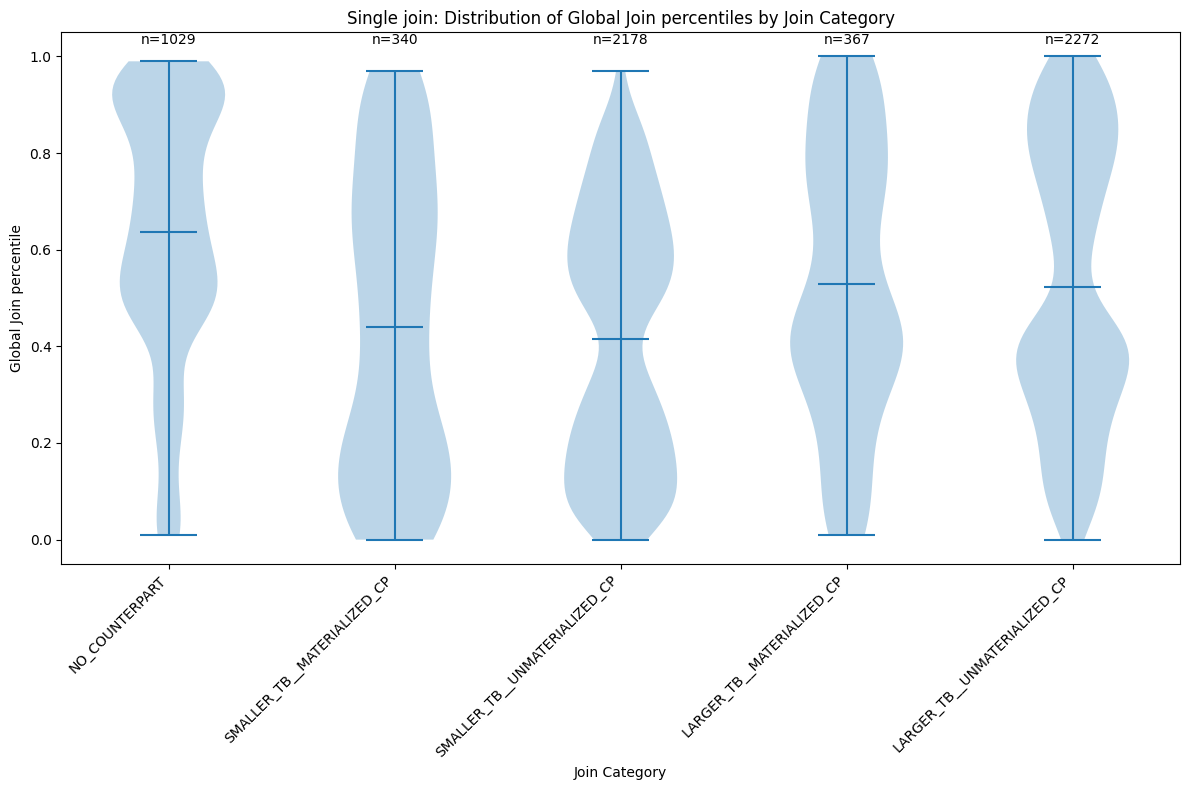

In [665]:
# Global percentiles
join_category_global_percentiles = {}
for cat in JoinCategory:
    data = single_join_df[single_join_df['Join Category']
                            == cat]['Global Join Percentile']
    if len(data) > 0:
        join_category_global_percentiles[cat.name] = data

fig, ax = plot_violin(
    join_category_global_percentiles,
    'Single join: Distribution of Global Join percentiles by Join Category',
    'Join Category',
    'Global Join percentile'
)

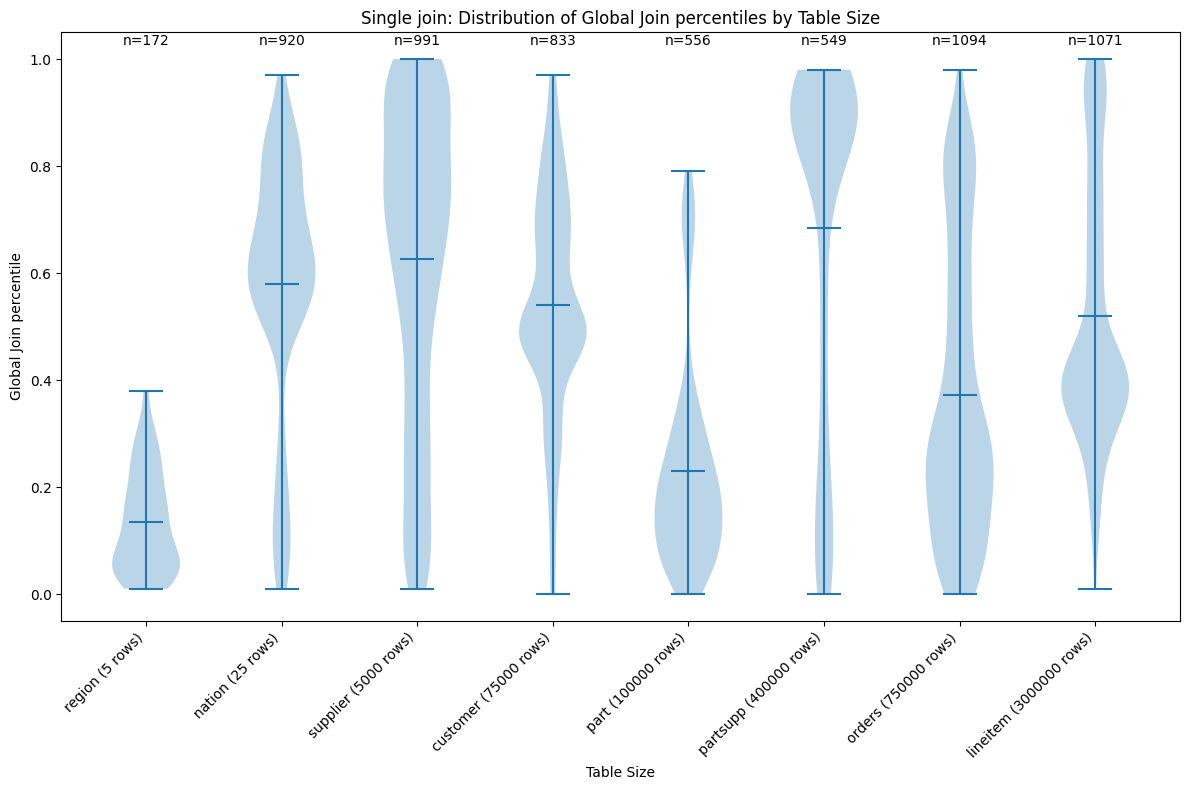

In [666]:
# Global join percentiles by table size
table_size_global_percentiles = {
    'region (5 rows)': single_join_df[single_join_df['Table size'] == 5]['Global Join Percentile'],
    'nation (25 rows)': single_join_df[single_join_df['Table size'] == 25]['Global Join Percentile'],
    'supplier (5000 rows)': single_join_df[single_join_df['Table size'] == 5000]['Global Join Percentile'],
    'customer (75000 rows)': single_join_df[single_join_df['Table size'] == 75000]['Global Join Percentile'],
    'part (100000 rows)': single_join_df[single_join_df['Table size'] == 100000]['Global Join Percentile'],
    'partsupp (400000 rows)': single_join_df[single_join_df['Table size'] == 400000]['Global Join Percentile'],
    'orders (750000 rows)': single_join_df[single_join_df['Table size'] == 750000]['Global Join Percentile'],
    'lineitem (3000000 rows)': single_join_df[single_join_df['Table size'] == 3000000]['Global Join Percentile']
}

fig, ax = plot_violin(
    table_size_global_percentiles,
    'Single join: Distribution of Global Join percentiles by Table Size',
    'Table Size',
    'Global Join percentile'
)

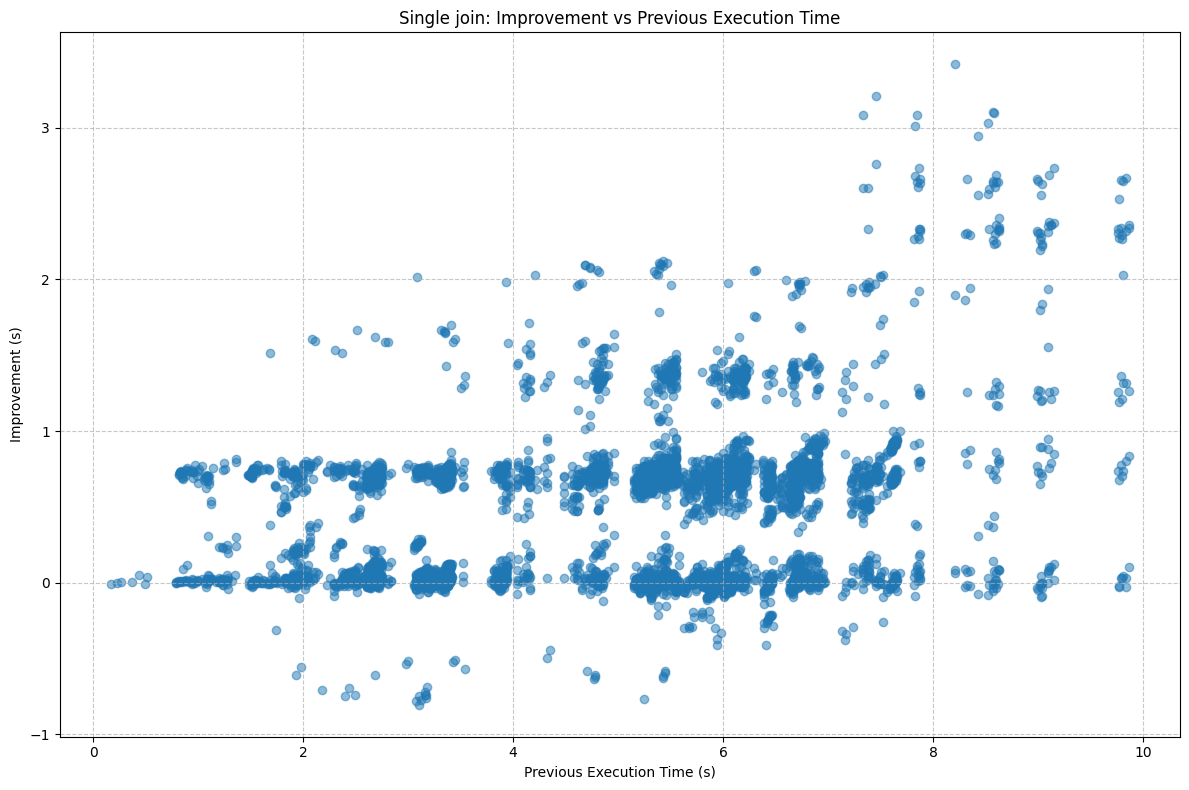

In [667]:
# Single join improvement scatter plot
fig, ax = plot_scatter(
    single_join_df['Previous Time'],
    single_join_df['Improvement'],
    'Single join: Improvement vs Previous Execution Time',
    'Previous Execution Time (s)',
    'Improvement (s)'
)

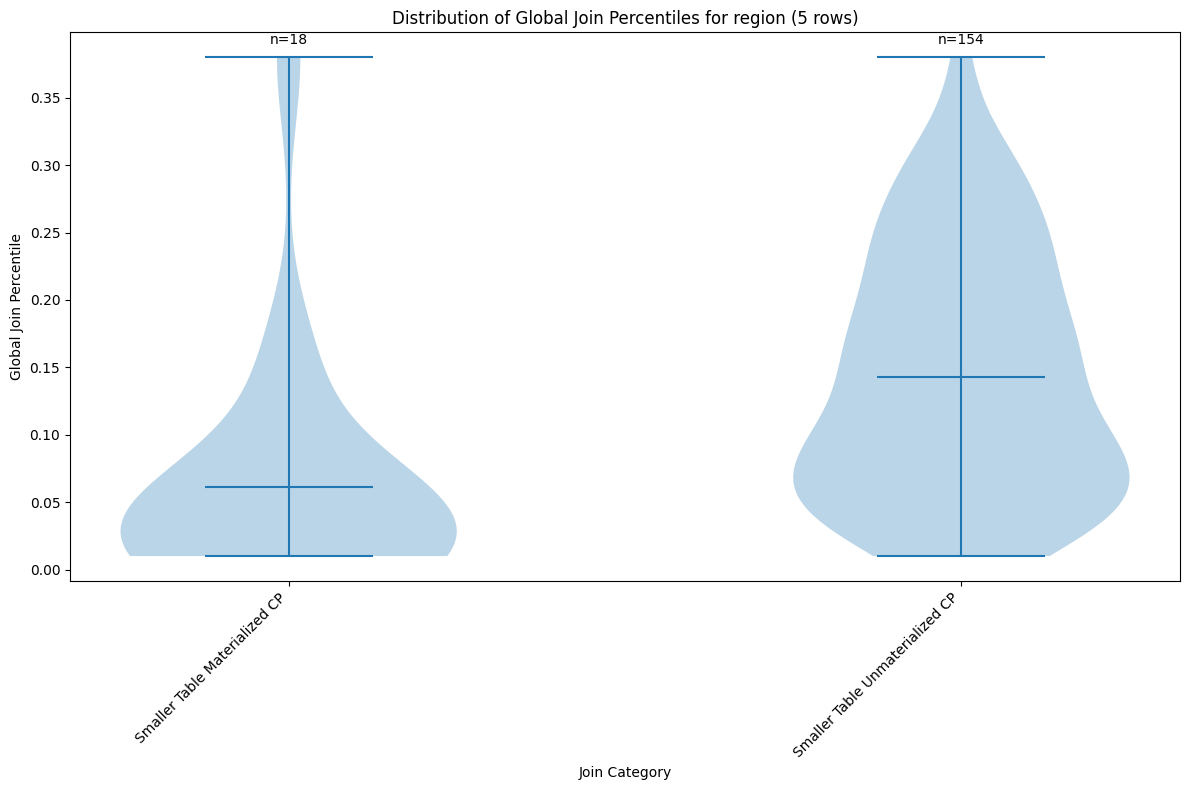

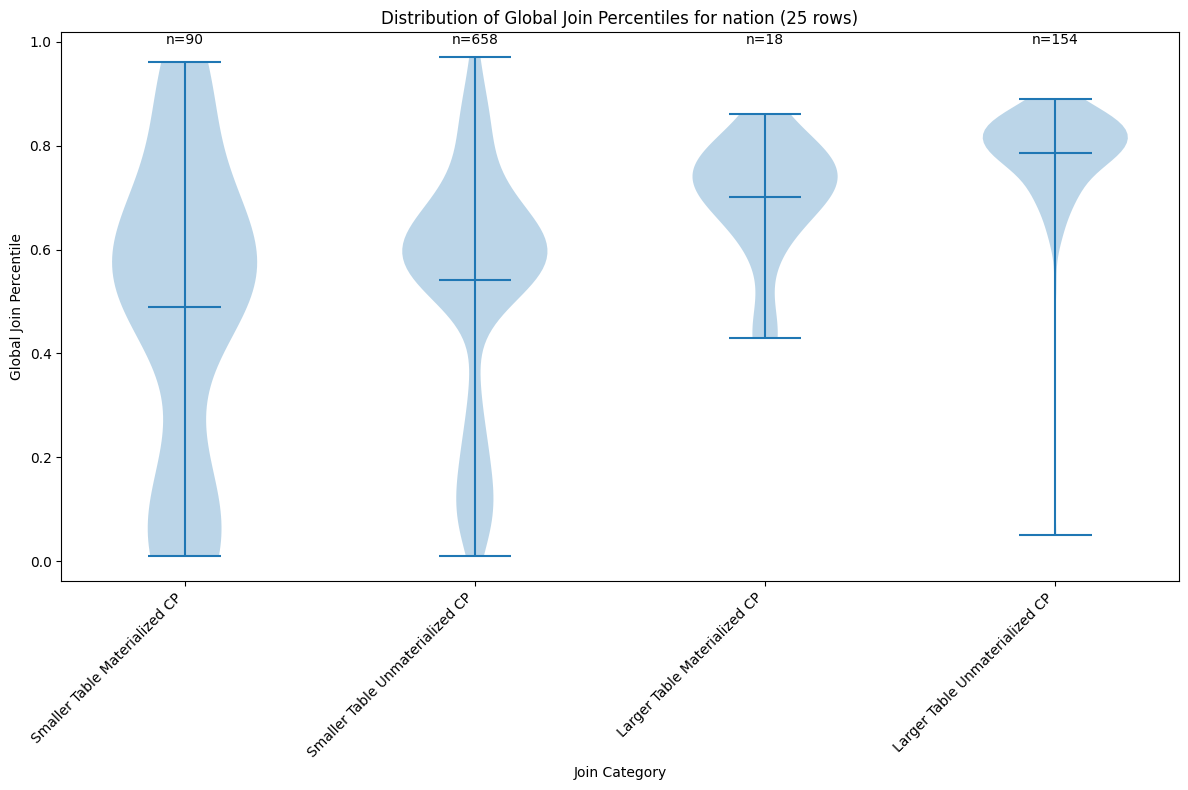

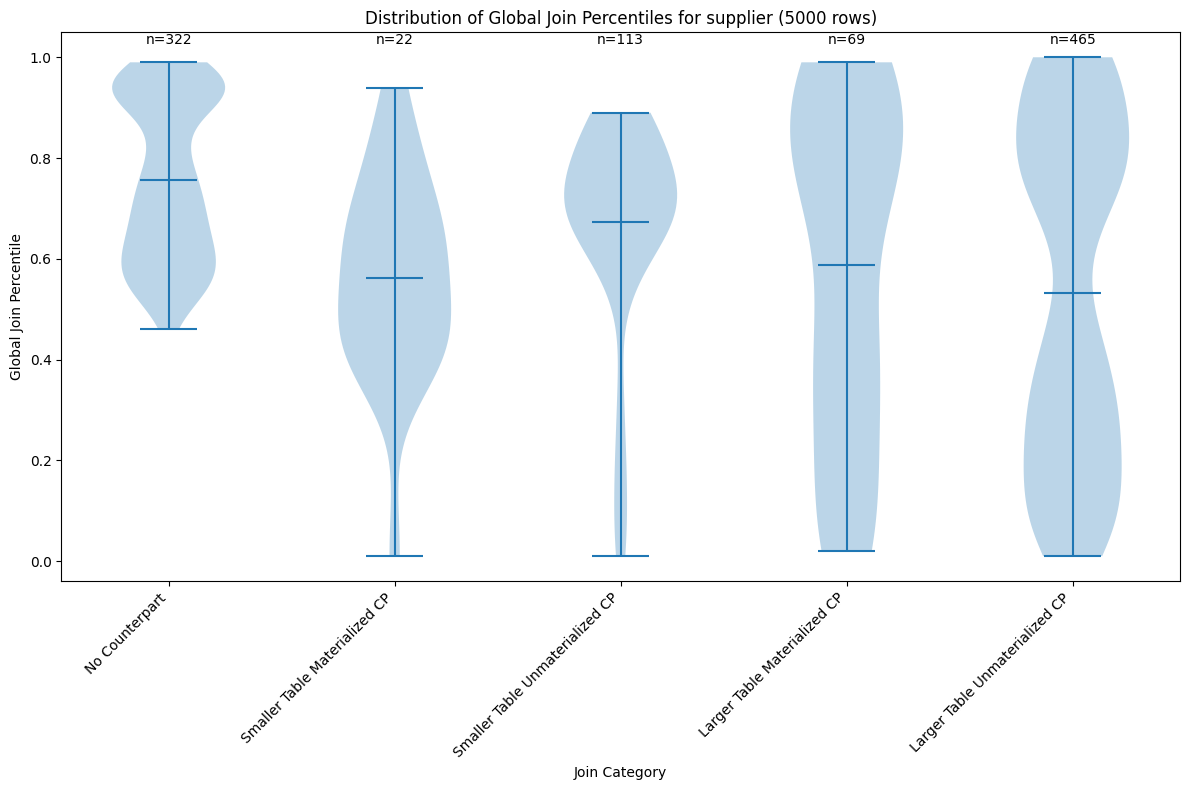

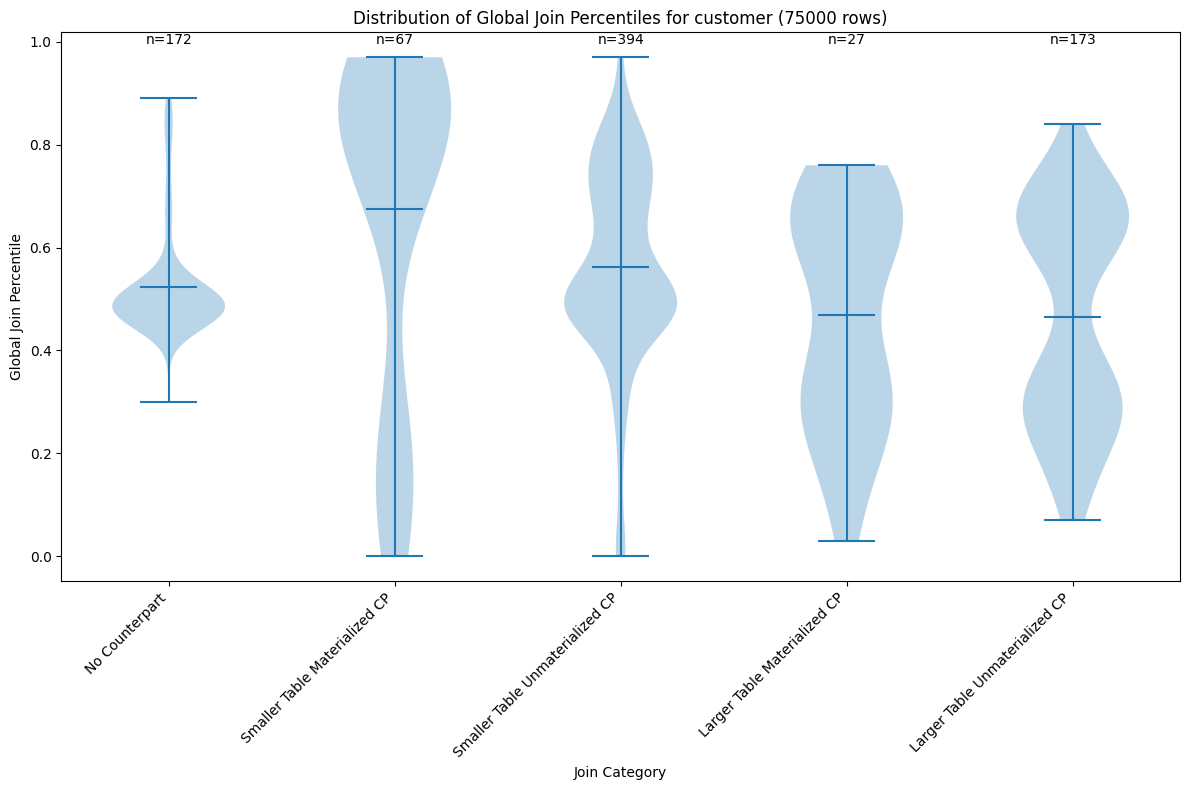

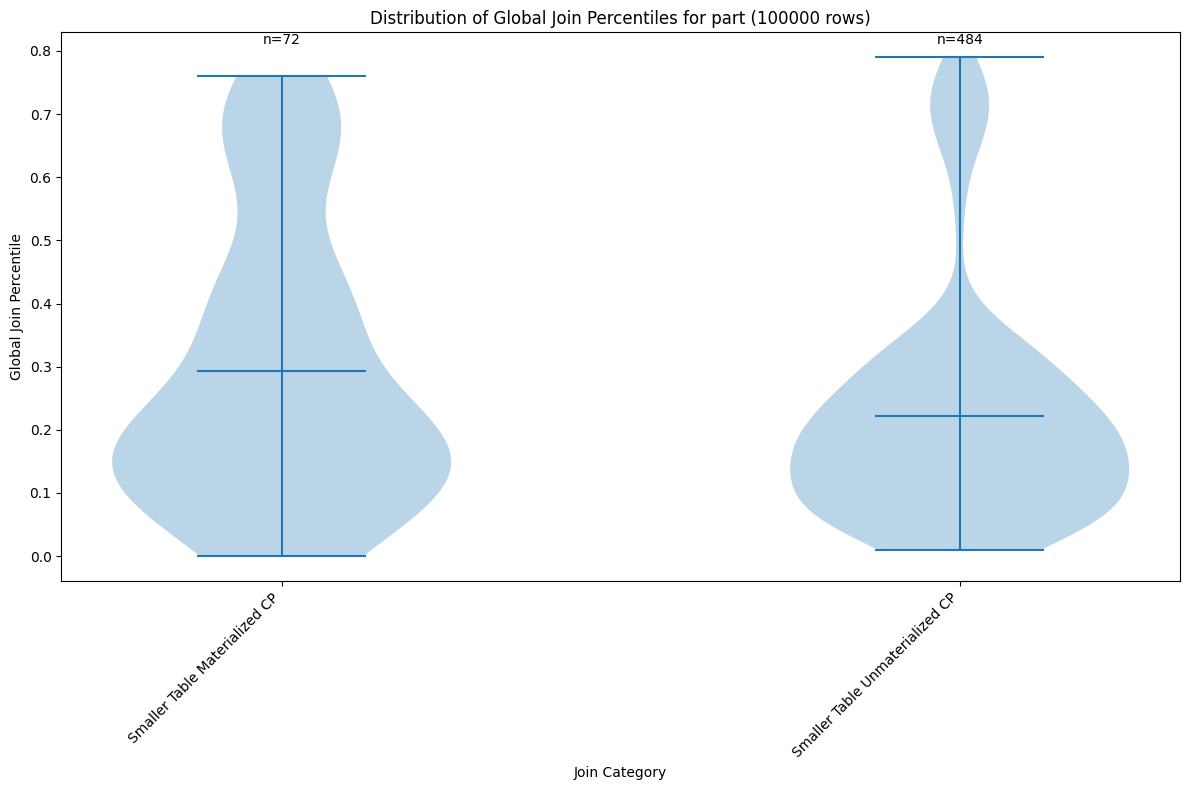

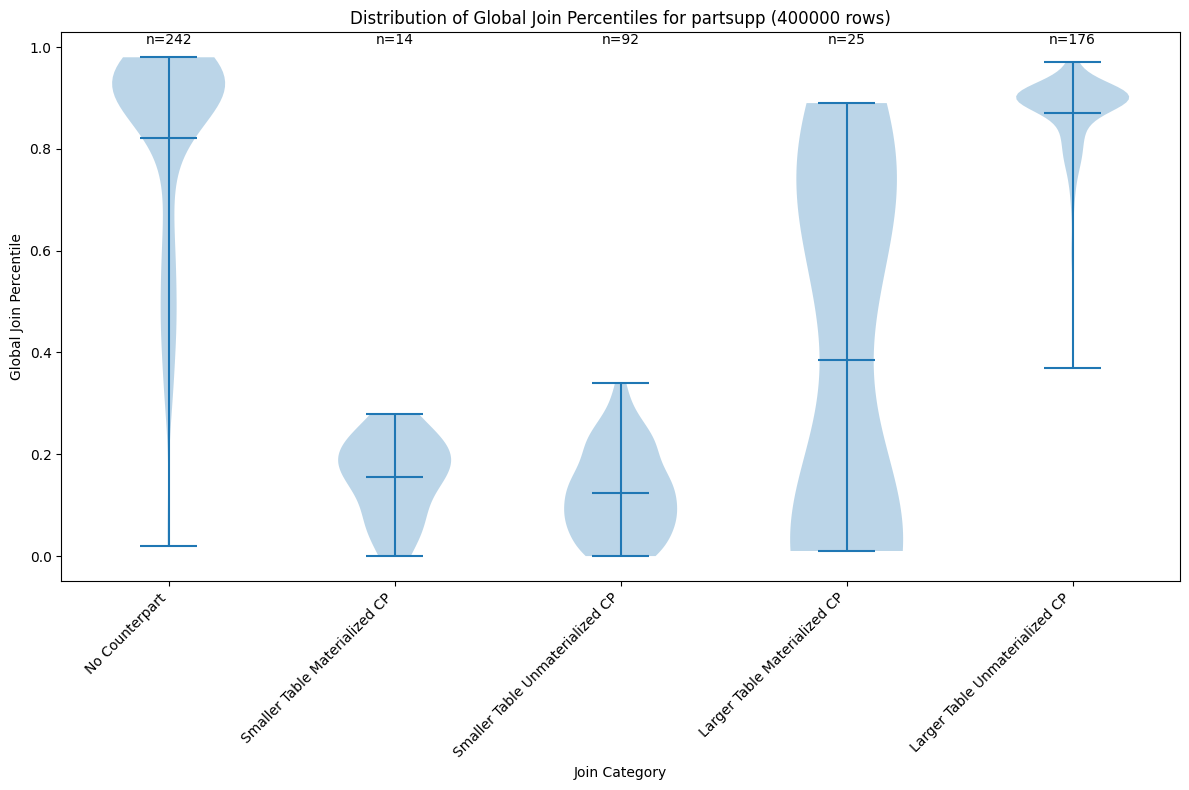

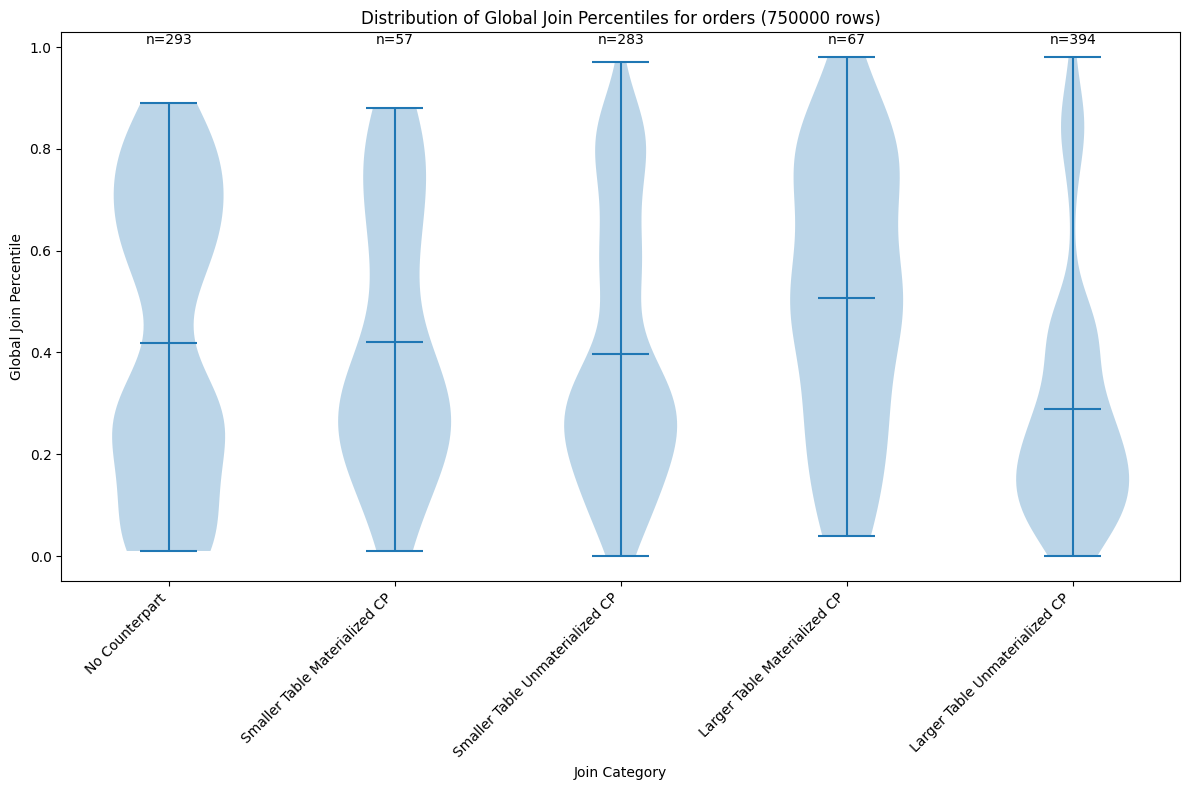

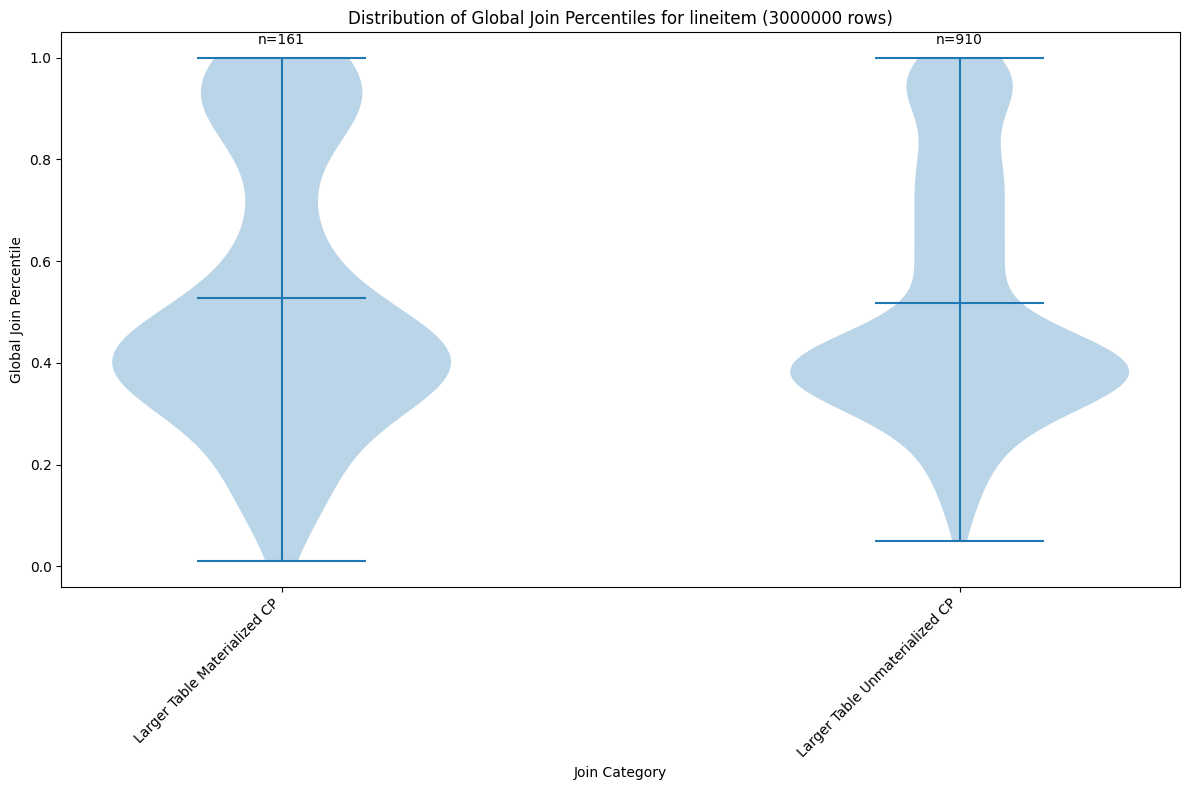

In [668]:
# Analyze join categories by table size
join_category_data, table_sizes, category_labels = analyze_join_category_by_table_size(
    single_join_df)

# Create violin plots for each table size
for size, label in table_sizes.items():
    if size in join_category_data:

        fig, ax = plot_violin(
            join_category_data[size]['global'],
            f'Distribution of Global Join Percentiles for {label}',
            'Join Category',
            'Global Join Percentile'
        )

In [669]:
# Analyze join counterparts
counterpart_data, table_sizes = analyze_join_counterparts(single_join_df)

# Create violin plots for each table size's counterparts
for size, label in table_sizes.items():
    if size in counterpart_data:
        fig, ax = plot_violin(
            counterpart_data[size]['global'],
            f'Distribution of Global Join Percentiles for {label} by Counterpart',
            'Join Counterpart',
            'Global Join Percentile'
        )

KeyError: 'query'

In [602]:
# Create violin plots for table sizes
global_table_sizes = {
    'region (5 rows)': results_df[results_df['Table size'] == 5]['Global Percentile'],
    'nation (25 rows)': results_df[results_df['Table size'] == 25]['Global Percentile'],
    'supplier (5000 rows)': results_df[results_df['Table size'] == 5000]['Global Percentile'],
    'customer (75000 rows)': results_df[results_df['Table size'] == 75000]['Global Percentile'],
    'part (100000 rows)': results_df[results_df['Table size'] == 100000]['Global Percentile'],
    'partsupp (400000 rows)': results_df[results_df['Table size'] == 400000]['Global Percentile'],
    'orders (750000 rows)': results_df[results_df['Table size'] == 750000]['Global Percentile'],
    'lineitem (3000000 rows)': results_df[results_df['Table size'] == 3000000]['Global Percentile']
}

fig, ax = plot_violin(
    global_table_sizes,
    'Distribution of Global Percentiles by Table Size',
    'Table Size',
    'Global Percentile'
)

# Single Where Section

In [603]:
# Analyze WHERE patterns
where_results = analyze_where_patterns(single_where_df)

# Plot WHERE results by column type
fig, ax = plot_bar(
    where_results['column_type']['query']['Column Type'],
    where_results['column_type']['query']['Count'],
    f'Column Types in WHERE Clauses (Query Percentile ≥ {PERCENTILE_THRESHOLD})',
    'Column Type',
    'Count'
)

In [604]:
# Create violin plots for WHERE percentiles by column type
where_column_types = {}
for ct in single_where_df['Column Type'].unique():
    data = single_where_df[single_where_df['Column Type']
                            == ct]['Query Where Percentile']
    if len(data) > 0:
        where_column_types[ct] = data

fig, ax = plot_violin(
    where_column_types,
    'Distribution of Query Percentiles by Column Type (WHERE)',
    'Column Type',
    'Query Percentile'
)

In [605]:
# Global WHERE percentiles by column type
where_column_types_global = {}
for ct in single_where_df['Column Type'].unique():
    data = single_where_df[single_where_df['Column Type']
                            == ct]['Global Where Percentile']
    if len(data) > 0:
        where_column_types_global[ct] = data

fig, ax = plot_violin(
    where_column_types_global,
    'Distribution of Global Percentiles by Column Type (WHERE)',
    'Column Type',
    'Global Percentile'
)